In [1]:
from collections import Counter
from itertools import islice
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('output.csv')
df

Opcodes  APT
0     MOV, RET, MOV, JMP, CMP, JNZ, RET, JMP, PUSH, ...    2
1     CMP, JNZ, RET, JMP, CMP, JNZ, CALL, PUSH, CALL...    2
2     CMP, JNZ, RET, JMP, CMP, JNZ, CALL, PUSH, CALL...    2
3     MOV, RET, MOV, JMP, CMP, JNZ, RET, JMP, PUSH, ...    2
4     PUSH, MOV, CALL, TESTB, JE, PUSH, CALL, POP, M...    3
...                                                 ...  ...
1030  PUSH, POP, MOV, MOV, INT, MOV, INT, PUSH, PUSH...   32
1031  PUSH, POP, MOV, MOV, INT, MOV, INT, PUSH, PUSH...   32
1032  PUSH, POP, MOV, MOV, INT, MOV, INT, PUSH, PUSH...   32
1033  PUSH, POP, MOV, MOV, INT, MOV, INT, PUSH, PUSH...   32
1034  PUSH, POP, MOV, MOV, INT, MOV, INT, PUSH, PUSH...   32

[1035 rows x 2 columns]

In [3]:
# ===================== 1-GRAM PROCESSING =====================
unique_1grams = set()
for opcodes in df['Opcodes']:
    unique_1grams.update(op.strip() for op in opcodes.split(', '))

unique_1grams = sorted(unique_1grams)
one_gram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_1grams)

for i, row in df.iterrows():
    opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
    counts_1gram = Counter(opcode_list)

    for opcode, count in counts_1gram.items():
        one_gram_counts_df.at[i, opcode] = count

x_1gram = one_gram_counts_df.values
y_1gram = df['APT'].values

In [4]:
# ===================== 2-GRAM PROCESSING =====================
def generate_2grams(sequence):
    """Generate 2-grams from a sequence of opcodes."""
    return ['{'+', '.join(sequence[i:i + 2])+'}' for i in range(len(sequence) - 2 + 1)]

unique_2grams = set()
for opcodes in df['Opcodes']:
    opcode_list = [op.strip() for op in opcodes.split(', ')]
    two_grams = generate_2grams(opcode_list)
    unique_2grams.update(two_grams)
print(unique_2grams)
unique_2grams = sorted(unique_2grams)
two_gram_counts_df = pd.DataFrame(0, index=range(len(df)), columns=unique_2grams)

for i, row in df.iterrows():
    opcode_list = [op.strip() for op in row['Opcodes'].split(', ')]
    two_grams = generate_2grams(opcode_list)
    counts_2gram = Counter(two_grams)

    for two_gram, count in counts_2gram.items():
        two_gram_counts_df.at[i, two_gram] = count

x_2gram = two_gram_counts_df.values

{'{JO, PUSHA}', '{JBE, CMPW}', '{FWAIT, DAS}', '{FMULP, FIMUL}', '{POP, INSL}', '{OUTSB, SUB}', '{INSL, PUSH}', '{LRET, DEC}', '{MOVSB, NEG}', '{POP, DIVL}', '{MOVAPS, PSRLDQ}', '{PUSHF, ROR}', '{VPADDD, XOR}', '{FBLD, OUT}', '{REPZ, FDIVR}', '{VMOVQ, BTR}', '{SBB, LCALL}', '{LOOPE, LOOP}', '{ADCB, ADC}', '{JECXZ, RCLL}', '{PCLMULLQLQDQ, MOVUPS}', '{FISTL, POPF}', '{ORL, TESTW}', '{SCAS, GS}', '{POP, FDIVRL}', '{JG, LDS}', '{CLTD, FICOMPL}', '{JAE, SCAS}', '{ANDL, JNO}', '{LEA, PUNPCKLDQ}', '{FSUBRL, ADC}', '{JP, FSUBR}', '{FCOMPL, CLD}', '{SAR, DAA}', '{POPAW, LOOP}', '{DIV, FIDIV}', '{RET, FSTPT}', '{RETF, JG}', '{FILDLL, INTO}', '{JAE, ADD}', '{ADD, POPF}', '{LJMP, JNS}', '{ADD, JB}', '{MOVZX, LEAVE}', '{FNSTENV, IMUL}', '{LAHF, RORB}', '{JG, MOVQ}', '{XCHG, IN}', '{FWAIT, CLTD}', '{RORL, FUCOMI}', '{IDIVL, REPNZ}', '{XOR, AND}', '{JNC, LAHF}', '{AND, IDIVB}', '{FISUBRL, PUSH}', '{CWTL, POPA}', '{PUSH, DECL}', '{XOR, JC}', '{FCOMPS, INT3}', '{INSL, CLTD}', '{JMP, FICOMP}', '{FSTPS, 

In [5]:
print("1-Gram Feature Matrix (first few rows):")
print(one_gram_counts_df.head())
print("\nShape of x_1gram:", x_1gram.shape)


print("\n2-Gram Feature Matrix (first few rows):")
print(two_gram_counts_df.head())
print("\nShape of x_2gram:", x_2gram.shape)

1-Gram Feature Matrix (first few rows):
   (BAD)  .BYTE  AAA  AAD  AAM  AAS  ADC  ADC.LOCK  ADCB  ADCL  ...  srlv  \
0      0      0    0    0    0    0    0         0     0     0  ...     0   
1      0      0    0    0    0    0    0         0     0     0  ...     0   
2      0      0    0    0    0    0    1         0     0     0  ...     0   
3      0      0    0    0    0    0    0         0     0     0  ...     0   
4      0      0    0    0    0    0    0         0     0     0  ...     0   

   sub.D  subu  sw  swc1  swl  swr  syscall  xor  xori  
0      0     0   0     0    0    0        0    0     0  
1      0     0   0     0    0    0        0    0     0  
2      0     0   0     0    0    0        0    0     0  
3      0     0   0     0    0    0        0    0     0  
4      0     0   0     0    0    0        0    0     0  

[5 rows x 975 columns]

Shape of x_1gram: (1035, 975)

2-Gram Feature Matrix (first few rows):
   {(BAD), (BAD)}  {(BAD), AAA}  {(BAD), AAD}  {(BAD), AAM}

Results for 1-gram features:

SVM Model (1-gram)
Accuracy: 0.48792270531400966
Classification Report:
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.45      0.49      0.47        59
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         4
           8       0.70      0.68      0.69        38
           9       0.00      0.00      0.00         1
          10       1.00      0.16      0.28        25
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          20       0.00      0.0

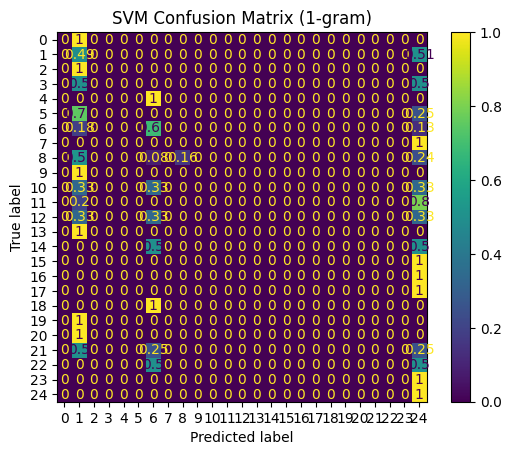



k-NN Model (1-gram)
Accuracy: 0.7874396135265701
Classification Report:
               precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           3       0.95      0.92      0.93        59
           4       0.00      0.00      0.00         1
           5       0.33      0.50      0.40         2
           6       0.50      1.00      0.67         1
           7       1.00      0.75      0.86         4
           8       0.75      0.87      0.80        38
           9       0.00      0.00      0.00         1
          10       0.83      0.96      0.89        25
          12       0.50      1.00      0.67         1
          13       0.20      0.33      0.25         3
          15       1.00      0.20      0.33         5
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          20       0.50      1.00      0.67         2
      

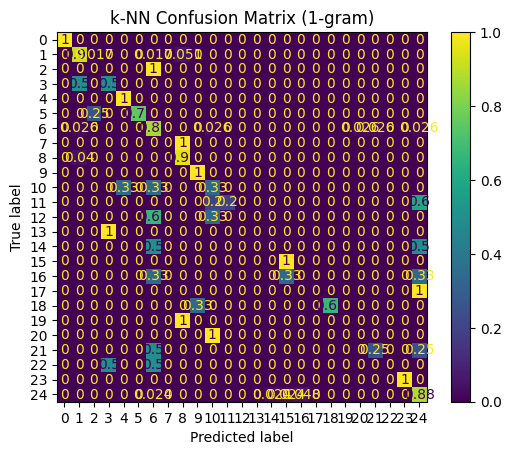



Decision Tree Model (1-gram)
Accuracy: 0.8357487922705314
Classification Report:
               precision    recall  f1-score   support

           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00        59
           4       0.00      0.00      0.00         1
           5       0.40      1.00      0.57         2
           6       0.50      1.00      0.67         1
           7       1.00      0.75      0.86         4
           8       0.94      0.87      0.90        38
           9       0.33      1.00      0.50         1
          10       0.92      0.92      0.92        25
          12       1.00      1.00      1.00         1
          13       0.33      0.67      0.44         3
          15       0.80      0.80      0.80         5
          16       0.50      0.33      0.40         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          20       0.33      0.50      0.40        

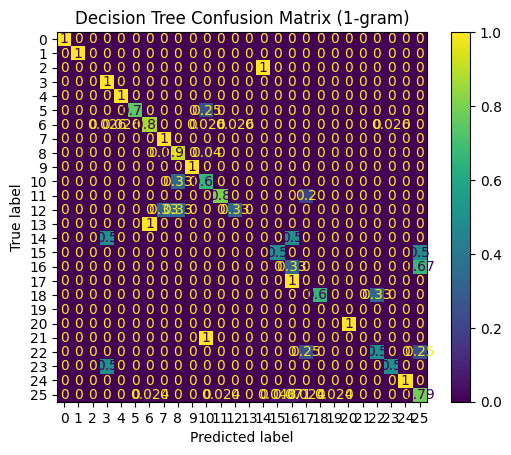



Results for 2-gram features:



In [ ]:
models = {
    'SVM': SVC(),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier()
}

print("Results for 1-gram features:\n")
X1_train, X1_test, y1_train, y1_test = train_test_split(x_1gram, y_1gram, test_size=0.2, random_state=6530, stratify=y_1gram)
for name, model in models.items():
    model.fit(X1_train, y1_train)
    y1_pred = model.predict(X1_test)
    print(f"{name} Model (1-gram)")
    print("Accuracy:", accuracy_score(y1_test, y1_pred))
    print("Classification Report:\n", classification_report(y1_test, y1_pred, zero_division=0))
    print("Confusion Matrix:\n")
    cm = confusion_matrix(y1_test, y1_pred, normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{name} Confusion Matrix (1-gram)")
    plt.show()
    print("\n")

print("Results for 2-gram features:\n")
X2_train, X2_test, y2_train, y2_test = train_test_split(x_2gram, y_1gram, test_size=0.2, random_state=6530, stratify=y_1gram)
for name, model in models.items():
    model.fit(X2_train, y2_train)
    y2_pred = model.predict(X2_test)
    print(f"{name} Model (2-gram)")
    print("Accuracy:", accuracy_score(y2_test, y2_pred))
    print("Classification Report:\n", classification_report(y2_test, y2_pred, zero_division=0))

    print("Confusion Matrix:\n")
    cm = confusion_matrix(y2_test, y2_pred, normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{name} Confusion Matrix (2-gram)")
    plt.show()
    print("\n")